In [326]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
pd.set_option('chained_assignment',None)
import matplotlib.ticker as ticker
from scipy import stats
import ast
import random
from scipy import stats
import random
from fractions import Fraction
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker

In [74]:
def interval_type(s):
    """Parse interval string to Interval"""
    
    table = str.maketrans({'[': '(', ']': ')'})
    left_closed = s.startswith('[')
    right_closed = s.endswith(']')

    left, right = ast.literal_eval(s.translate(table))

    t = 'neither'
    if left_closed and right_closed:
        t = 'both'
    elif left_closed:
        t = 'left'
    elif right_closed:
        t = 'right'

    return pd.Interval(left, right, closed=t)

In [17]:
from itertools import chain

from matplotlib.collections import LineCollection
from matplotlib import markers
from matplotlib.path import Path
import math
import numpy as np

from ete3 import Tree, NodeStyle

def round_sig(x, sig=2):
    return round(x, sig - int(math.floor(np.log10(abs(x)))) - 1)


def to_coord(x, y, xmin, xmax, ymin, ymax, plt_xmin, plt_ymin, plt_width, plt_height):
    x = (x - xmin) / (xmax - xmin) * plt_width  + plt_xmin
    y = (y - ymin) / (ymax - ymin) * plt_height + plt_ymin
    return x, y


def plot_tree(tree, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=None, **kwargs):
    """
    Plots a ete3.Tree object using matploltib.
    
    :param tree: ete Tree object
    :param False align_names: if True names will be aligned vertically
    :param None max_dist: if defined any branch longer than the given value will be 
       reduced by this same value.
    :param None name_offset: offset relative to tips to write leaf_names. In bL scale
    :param 12 font_size: to write text
    :param None axe: a matploltib.Axe object on which the tree will be painted.
    :param kwargs: for tree edge drawing (matplotlib LineCollection) 
    :param 1 ms: marker size for tree nodes (relative to number of nodes)
    
    :returns: a dictionary of node objects with their coordinates
    """
    
    if axe is None:
        axe = plt.subplot(111)

    
    def __draw_edge_nm(c, x):
        h = node_pos[c]
        hlinec.append(((x, h), (x + c.dist, h)))
        hlines.append(cstyle)
        return (x + c.dist, h)

    def __draw_edge_md(c, x):
        h = node_pos[c]
        if c in cut_edge:
            offset = max_x / 600.
            hlinec.append(((x, h), (x + c.dist / 2 - offset, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + offset, h), (x + c.dist, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2, h - 0.05), (x + c.dist / 2 - 2 * offset, h + 0.05)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + 2 * offset, h - 0.05), (x + c.dist / 2, h + 0.05)))
            hlines.append(cstyle)
            axe.text(x + c.dist / 2, h - 0.07, '+%g' % max_dist, va='top', 
                     ha='center', size=2. * font_size / 3)
        else:
            hlinec.append(((x, h), (x + c.dist, h)))
            hlines.append(cstyle)
        return (x + c.dist, h)

    __draw_edge = __draw_edge_nm if max_dist is None else __draw_edge_md
    
    vlinec = []
    vlines = []
    hlinec = []
    hlines = []
    nodes = []
    nodex = []
    nodey = []
    ali_lines = []
    
    # to align leaf names
    tree = tree.copy()
    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    coords = {}
    node_pos = dict((n2, i) for i, n2 in enumerate(tree.get_leaves()[::-1]))
    node_list = tree.iter_descendants(strategy='postorder')
    node_list = chain(node_list, [tree])

    # reduce branch length
    cut_edge = set()
    if max_dist is not None:
        for n in tree.iter_descendants():
            if n.dist > max_dist:
                n.dist -= max_dist
                cut_edge.add(n)

    if name_offset is None:
        name_offset = max_x / 100.
    # draw tree
    for n in node_list:
        style = n._get_style()
        x = __builtin__.sum(n2.dist for n2 in n.iter_ancestors()) + n.dist
        if n.is_leaf():
            y = node_pos[n]
            tls = {"Pseudonaja_textilis": "Brown_snake", "Pantherophis_guttatus":"Corn_snake", "Thamnophis_elegans":"Garter_snake"}
            name = "\n".join(tls[n.name].split("_"))
            if align_names:
                axe.text(max_x + name_offset, y, "{}".format(name),
                         va='center', size=font_size) #, style='italic'
                ali_lines.append(((x, y), (max_x + name_offset, y)))
            else:
                axe.text(x + name_offset, y, "{}".format(name),
                         va='center', size=font_size)
        else:
            y = np.mean([node_pos[n2] for n2 in n.children])
            node_pos[n] = y

            # draw vertical line
            vlinec.append(((x, node_pos[n.children[0]]), (x, node_pos[n.children[-1]])))
            vlines.append(style)

            # draw horizontal lines
            for child in n.children:
                cstyle = child._get_style()
                coords[child] = __draw_edge(child, x)
        nodes.append(style)
        nodex.append(x)
        nodey.append(y)

    # draw root
    __draw_edge(tree, 0)

    lstyles = ['-', '--', ':']
    hline_col = LineCollection(hlinec, colors=[l['hz_line_color'] for l in hlines], 
                              linestyle=[lstyles[l['hz_line_type']] for l in hlines],
                              linewidth=[(l['hz_line_width'] + 1.) / 2 for l in hlines])
    vline_col = LineCollection(vlinec, colors=[l['vt_line_color'] for l in vlines], 
                              linestyle=[lstyles[l['vt_line_type']] for l in vlines],
                              linewidth=[(l['vt_line_width'] + 1.) / 2 for l in vlines])
    ali_line_col = LineCollection(ali_lines, colors='k')

    axe.add_collection(hline_col)
    axe.add_collection(vline_col)
    axe.add_collection(ali_line_col)
    axe.scatter(0,0, s=0)
    #nshapes = dict((('circle', 'o'), ('square', 's'), ('sphere', 'o')))
    #shapes = set(n['shape'] for n in nodes)
    #print(nodes)
    #for shape in shapes:
    #    indexes = [i for i, n in enumerate(nodes) if n['shape'] == shape]
    #    scat = axe.scatter([nodex[i] for i in indexes], 
    #                       [nodey[i] for i in indexes], 
    #                       s=0, marker=nshapes.get(shape, shape))
    #    scat.set_sizes([(nodes[i]['size'])**2 / 2 for i in indexes])
    #    scat.set_color([nodes[i]['fgcolor'] for i in indexes])
    #    scat.set_zorder(10)

    # scale line
    #xmin, xmax = axe.get_xlim()
    #ymin, ymax = axe.get_ylim()
    #diffy = ymax - ymin
    #dist = round_sig((xmax - xmin) / 5, sig=1)
    #ymin -= diffy / 100.
    #axe.plot([xmin, xmin + dist], [ymin, ymin], color='k')
    #axe.plot([xmin, xmin], [ymin - diffy / 200., ymin + diffy / 200.], color='k')
    #axe.plot([xmin + dist, xmin + dist], [ymin - diffy / 200., ymin + diffy / 200.], 
    #         color='k')
    #axe.text((xmin + xmin + dist) / 2, ymin - diffy / 200., dist, va='top',
    #         ha='center', size=font_size)
    #axe.set_axis_off()
    #axe.get_yaxis().set_visible(False)
    return coords

In [18]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''
    if len(y.dropna())>0:
        z = lowess(np.array(y),np.array(x),frac=0.12)
        y2 = z[:,1]
        plt.plot(x,y2, **kwargs)
    
def subplot_lowess(x, y, ax, **kwargs):
    '''Plots lowess line depending on fraction'''

    z = lowess(np.array(y),np.array(x),frac=0.18)
    y2 = z[:,1]
    ax.plot(x,y2, **kwargs)

def control_ylim(x, y, **kwargs):
    maxy = max(y)
    miny = min(y)
    print(maxy, miny)
    plt.ylim([miny,maxy])

Read data

In [19]:
d = pd.read_csv("../merged_results/merged.parsimony.tab.gz", sep="\t", header=None)
d.columns = ["branch", "gcstar", "derived_subs", "bps", "rel_pos", "cpgi1", "cpgi2", "spot_meg", "nature", "lift_bp", "dist_bp", "heat", "spot_id"]
d = d[(d.cpgi2>=0) & (d.cpgi1>=0)].reset_index()

Split the "nature" col into "spot" and "sp"

In [20]:
d["spot"] = [n.split(".")[1] for n in d.nature]
d["sp"] = [n.split(".")[0] for n in d.nature]

Classify into close or far from CpG islands

In [21]:
th = 500
#d["cpgi1_bool"] = ["close" if distance<=th else "far" if distance>=10e3 else "intermediate" for distance in d.cpgi1]
d["cpgi2_bool"] = ["close" if distance<=th else "far" if distance>th else "intermediate" for distance in d.cpgi2]
#class_hot = {spot_id:list(set(df["cpgi2_bool"].values)) for spot_id,df in d[(d.spot=="hotspots")].groupby("spot_id")}
#d = d[d.spot_id.isin(class_hot.keys())]
#d["cpgi2_bool"] = [class_hot[spot_id][0] for spot_id in d.spot_id]

In [22]:
d.groupby("cpgi2_bool").size()

cpgi2_bool
close    1767240
far      5557663
dtype: int64

Classify as shared or not

In [23]:
th = 1500
d["shared"] = ["shared" if lift>th else "not-shared" for lift in d.lift_bp]

Macro vs micro

In [24]:
ctypes = pd.read_csv("../misc_files/corn_macro_micro_dnazoo.tab",sep="\t").set_index("scaf")["nature"].to_dict()
d["ctype"] = d['spot_id'].str.split(":").str[0].map(ctypes)

Compute mean GC* across windows centered from spots

In [25]:
d["hue_kind"] = d.spot + "." + d.cpgi2_bool
subd = d[(d.bps>100) &
         (d.heat>5) &
         (d.cpgi2_bool!="intermediate")]
mtype = subd.groupby(["ctype","branch", "rel_pos", "hue_kind", "sp"])["gcstar"].mean().reset_index() 
mall = subd.groupby(["branch", "rel_pos", "hue_kind", "sp"])["gcstar"].mean().reset_index() 
mall["ctype"] = "all"
m = pd.concat([mtype, mall])

In [26]:
plotd = m[(m["rel_pos"].between(-6000,6000)) & 
          (m.sp=="corn")]
plotd["kind"] = [x.split(".")[1] for x in plotd.hue_kind]

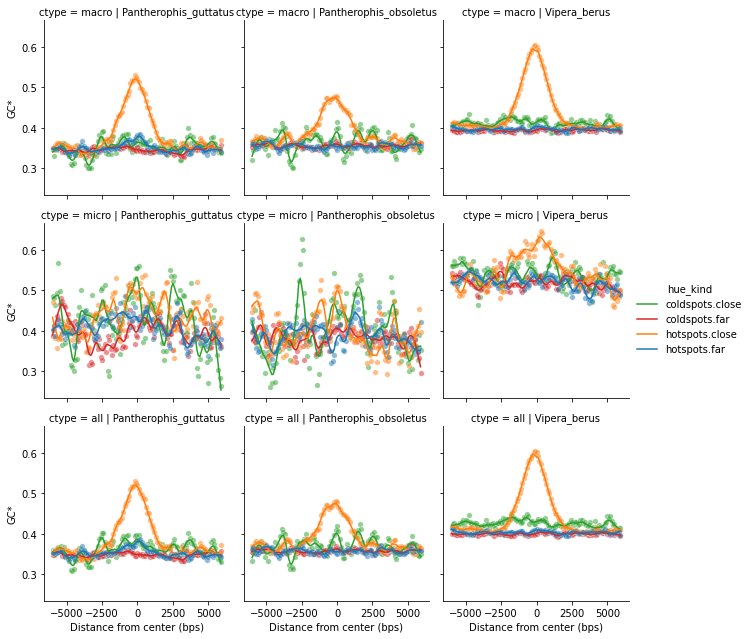

In [27]:
def plot_lowess(x, y, *args, **kwargs):
    '''Plots lowess line depending on fraction'''
    z = lowess(np.array(y),np.array(x), frac=0.08)
    y2 = z[:,1]
    epice = np.average(y[58:62])
    flank = np.average(y[:20])
#    print(epice/flank)
    plt.plot(x,y2,**kwargs)
    
#(plotd.hue_kind.str.contains("hot")) & 
g = sns.FacetGrid(data=plotd[(~plotd.branch.str.contains("Crot"))], col="branch", 
                  row = "ctype",
                  hue="hue_kind", 
                  palette = {"hotspots.close":"C1", "hotspots.far":"C0", 
                             "coldspots.close":"C2", "coldspots.far":"C3"},
                  height=3)
g.map(sns.scatterplot, "rel_pos", "gcstar", s=30, alpha=0.5)
g.map(plot_lowess, "rel_pos", "gcstar")
g.set_axis_labels("Distance from center (bps)", "GC*")
g.set_titles(col_template = '{col_name}')
g.add_legend()
#plt.tight_layout()
#g.savefig("pdfs/corn_hotspots_lineagespecific_parsimony.pdf")

### Main figure

TimeTree nwk phylogeny

In [15]:
#nwk = "((((Pseudonaja_textilis:26.52342000,Laticauda_laticaudata:26.52342000)'15':5.43885000,Naja_naja:31.96227000)'14':9.16414000,(Thamnophis_elegans:38.06070000,Pantherophis_guttatus:38.06070000)'26':3.06571000)'38':0.50127000,(Vipera_berus:34.38732000,Crotalus_viridis:34.38732000)'37':7.24036000);"
#nwk = "(Pseudonaja_textilis:37.84692000,(Pantherophis_guttatus:34.71135000,Thamnophis_elegans:34.71135000)'14':3.13557000);"
nwk = "((Pantherophis_guttatus:34.71135000,Thamnophis_elegans:34.71135000)'14':3.47835000,Vipera_berus:38.18970000);"
t = Tree(nwk, format=1)

In [16]:
data = {sp:df for sp,df in plotd.groupby("branch")}

In [17]:
[dist for dist,df in subd.groupby("hue_kind")]

['coldspots.close', 'coldspots.far', 'hotspots.close', 'hotspots.far']

In [16]:
import pickle 

with open('../../../figures_final/data/Figure3b_Data_micromacro.pkl', 'wb') as f:
    pickle.dump(data, f)

Background rates

In [121]:
back = pd.read_csv("../misc_files/spots_backrates.tab",sep="\t", header=None)
back.columns = ["spot_id", "backrate", "nature"]
#back = pd.read_csv("../misc_files/spots_backrates_ldhelmet.tab",sep="\t", header=None)
#back.columns = ["spot_id", "backrate"] 
#back["nature"] = "hotspot"

In [128]:
back_d = back.set_index("spot_id")["backrate"].to_dict()
corn_macro = d[(d.branch=="Pantherophis_guttatus")].reset_index()
corn_macro["backrate"] = corn_macro["spot_id"].map(back_d)
# Perform qcut on 'backrate'
corn_macro["backbin"] = pd.qcut(corn_macro['backrate'], 20, duplicates='drop').astype(str)
micro_rates = corn_macro.loc[corn_macro.ctype == "micro", "backrate"].values
minr = "{:.6f}".format(np.percentile(micro_rates, 8))
maxr = "{:.6f}".format(np.percentile(micro_rates, 95))

# Assign a 'micro' label for those 'ctype' that are 'micro'
corn_macro.loc[corn_macro.ctype == "micro", "backbin"] = f"({minr}, {maxr}"

In [129]:
subd = corn_macro#[(corn_macro.bps>100) &
                 # (corn_macro.heat>5) &
                 # (corn_macro.cpgi2_bool!="intermediate")]
res = subd.groupby(["rel_pos", "hue_kind", "ctype", "backbin"])["gcstar"].mean().reset_index() 
res = res[res.rel_pos.between(-6000,6000)].reset_index()

In [130]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''
    if len(y.dropna())>0:
        z = lowess(np.array(y),np.array(x),frac=0.15)
        y2 = z[:,1]
        plt.plot(x,y2, **kwargs)

In [243]:
ssubd = subd[subd.hue_kind!="hotspots.close"]
ssubd["backbin"] = pd.qcut(ssubd['backrate'], 100, duplicates='drop').astype(str)

In [240]:
res = ssubd.groupby(["backbin"]).apply(calculate_gcheat).reset_index()

In [241]:
res["brate"] = res.apply(lambda row: interval_type(row.backbin).left, axis=1)

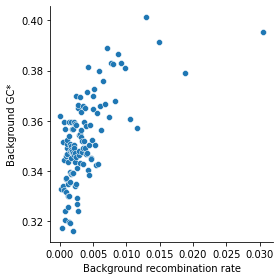

In [249]:
f,ax = plt.subplots(figsize=[4,4])
sns.scatterplot(data=res, x="backrate", y="gc_flank",ax=ax)
ax.set_xlabel("Background recombination rate")
ax.set_ylabel("Background GC*")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/background_vs.pdf")

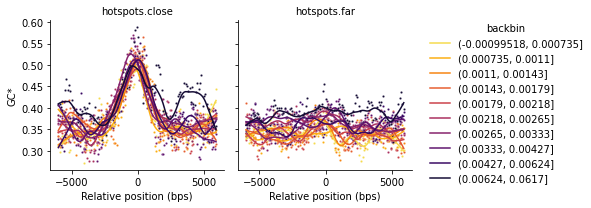

In [36]:
g = sns.FacetGrid(data=res[(res.hue_kind.str.contains("hot")) & (res.ctype=="macro")], 
                  col="hue_kind", hue="backbin", palette="inferno_r")
g.map(sns.scatterplot, "rel_pos", "gcstar", s=5)
g.map(plot_lowess, "rel_pos", "gcstar")
g.set_axis_labels("Relative position (bps)", "GC*")
g.set_titles(col_template = '{col_name}', 
             row_template = "{row_name}")
g.add_legend()
g.tight_layout()
#g.savefig("pdfs/hotspots_bin_backrate.pdf")

In [392]:
hots = corn_macro[corn_macro.hue_kind=="hotspots.close"]
hots["cbackbin"] = pd.qcut(hots.backrate, 50)

In [398]:
for r,df in hots.groupby("cbackbin"):
    pass

In [404]:
def safediv(n,d):
    return n/d if d>0 else np.nan

def calculate_gcheat(df):
    gc_center = df[df.rel_pos.between(-200,200)]["gcstar"].mean()
    gc_flank  = df[~df.rel_pos.between(-3000,3000)]["gcstar"].mean()
    gcheat = safediv(gc_center, gc_flank)
    rheat = df.heat.median()
    return pd.Series([df.hue_kind.values[0], 
                      df.backrate.mean(), 
                      gc_flank,
                      gcheat, 
                      rheat], 
                     index=["hue_kind", "backrate", "gc_flank", "gcheat", "heat"])

coll = hots.groupby("cbackbin").apply(calculate_gcheat).reset_index()

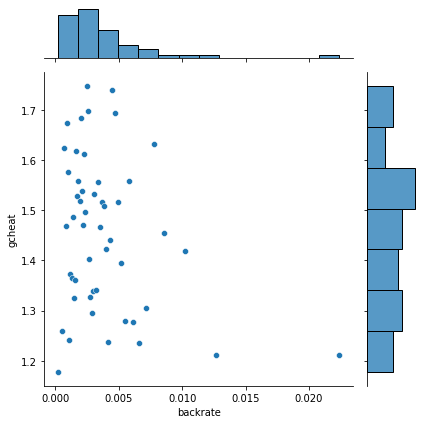

In [405]:
sns.jointplot(data=coll, x="backrate", y="gcheat")
plt.tight_layout()

Matching

In [256]:
micro = corn_macro[(corn_macro.ctype=="micro") & (corn_macro.hue_kind=="hotspots.close")].groupby("spot_id").head(1)
macro = corn_macro[(corn_macro.ctype=="macro") & (corn_macro.hue_kind=="hotspots.close")].groupby("spot_id").head(1)
tot_macro = corn_macro[(corn_macro.ctype=="macro") & (corn_macro.hue_kind=="hotspots.close")]
tot_micro = corn_macro[(corn_macro.ctype=="micro") & (corn_macro.hue_kind=="hotspots.close")]

In [257]:
h = corn_macro.groupby("spot_id").head(1)

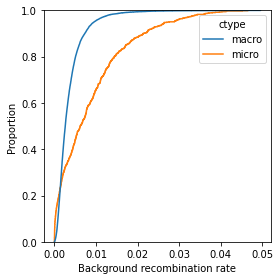

In [258]:
f,ax = plt.subplots(figsize=[4,4])
sns.ecdfplot(data=h[h.backrate<0.05], x="backrate", hue="ctype")
ax.set_xlabel("Background recombination rate")
plt.tight_layout()
#plt.savefig("pdfs/backrate_distribution.pdf")

<Axes: xlabel='backrate', ylabel='Proportion'>

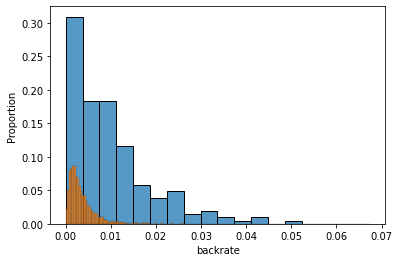

In [259]:
sns.histplot(data=micro, x="backrate", stat="proportion")
sns.histplot(data=macro, x="backrate", stat="proportion")

In [261]:
max_distance = 1e-3
distances = np.abs(macro['backrate'].values[:, None] - micro['backrate'].values)
within_distance = np.transpose(distances <= max_distance)
hits = [list(np.where(row)[0]) for row in within_distance]

In [365]:
l = []
l2 = [[k for k,z in zip(micro.backrate.values, hits) if len(z)>0]]
for r in range(500):
    subdf  = macro.iloc[[np.random.choice(h) for h in hits if len(h)>0]]
    ssubdf = tot_macro[tot_macro.spot_id.isin(subdf.spot_id.values)]
    ssubdf["rep"] = r
    l2.append(subdf.backrate.values)
    l.append(ssubdf)
tot_micro["rep"] = 999
l.append(tot_micro)
matched_macro = pd.concat(l)

In [366]:
res = matched_macro.groupby(["rel_pos", "hue_kind", "ctype", "rep"])["gcstar"].mean().reset_index() 
res = res[res.rel_pos.between(-6000,6000)].reset_index()

In [367]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''
    if len(y.dropna())>0:
        z = lowess(np.array(y),np.array(x),frac=0.15)
        y2 = z[:,1]
        plt.plot(x,y2, **kwargs)

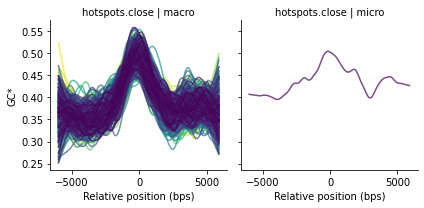

In [368]:
g = sns.FacetGrid(data=res[res.hue_kind.str.contains("hotspots")], 
                  row="hue_kind", col="ctype", 
                  hue="rep", palette="viridis_r")

g.map(plot_lowess, "rel_pos", "gcstar", alpha=0.7)

g.set_axis_labels("Relative position (bps)", "GC*")
g.set_titles(col_template = '{col_name}', 
             row_template = "{row_name}")

g.tight_layout()
g.savefig("pdfs/hotspots_matched_backrate.jpeg", dpi=100)

In [369]:
l = []
for rep,df in res.groupby("rep"):
    gc_center = df[df.rel_pos.between(-500,500)]["gcstar"].max()
    gc_flank  = df[~df.rel_pos.between(-3000,3000)]["gcstar"].mean()
    gcheat = safediv(gc_center, gc_flank)
    l.append([rep, gcheat, "rep" if rep<500 else "micro"])
r = pd.DataFrame(l)
r.columns = ["rep", "gcheat", "nature"]

In [370]:
def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[-1]
    shuf = v[:-1]
    margin = 1e-2
    perc = stats.percentileofscore(shuf, og, kind="strict") # 
    print(perc)
    r = sum([1 for u in v if u<=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    print(np.percentile(shuf, 2.5), np.percentile(shuf, 97.5), og)
    print("{:.3f}".format(og-np.percentile(shuf, 97.5)),
          "{:.3f}".format(og-np.percentile(shuf, 50)),
          "{:.3f}".format(og-np.percentile(shuf, 2.5)))
    
    print("---")
    rnd = random.uniform(0,0.2)
    N = len(y)-1
    ax = plt.gca()
    trans = transforms.blended_transform_factory(
    ax.transData,
    ax.transAxes  # For x
    )

    # Use the transform in the annotation
    #ax.annotate('Test', xy=(0.5, 2), xycoords=trans, ha='center', va='center')
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og +margin, 0.9), xycoords=trans, **kwargs)#0.78
    plt.annotate("n={}".format(N), xy=(og +margin, 0.835), xycoords=trans, **kwargs)# 0.73

AttributeError: 'pandas._libs.interval.Interval' object has no attribute 'nature'

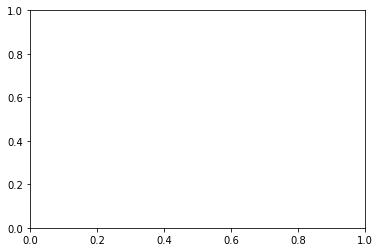

In [406]:
f,ax = plt.subplots()
sns.histplot(data = r[r.nature!="micro"], x="gcheat",
             element="step",stat="probability", 
             common_norm=False, line_kws={'linestyle': '--'}, alpha=0.2, 
             bins = 25,
             ax=ax)
ax.axvline(x=r[r.nature=="micro"]["gcheat"].values[0], color="salmon", linestyle="dotted")
annotate_perc(r.gcheat, r.gcheat)
sns.despine()
ax.set_xlabel("Relative increase in GC* at hotspots")
plt.tight_layout()
plt.savefig("pdfs/distrib_gcheats.jpeg", dpi=200)

In [374]:
rates = pd.DataFrame(l2).transpose().dropna()
rates.columns = [f"c{i}" for i in range(501)]

Text(0, 0.5, 'Background rate in matched macrochromosome hotspot')

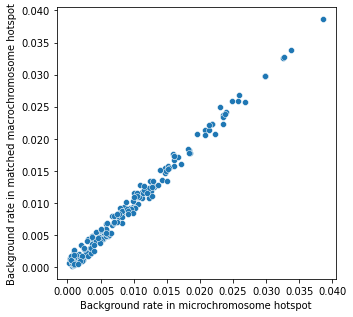

In [378]:
f,ax = plt.subplots(figsize=[5,5])
sns.scatterplot(data=rates, x="c5", y="c100",ax=ax)
ax.set_xlabel("Background rate in microchromosome hotspot")
ax.set_ylabel("Background rate in matched macrochromosome hotspot")